<a href="https://colab.research.google.com/github/izmare/Flux_Dev_i2i/blob/main/FluxDevi2i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.27.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

!wget https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/test.png -O /content/test.png

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro_extras import nodes_post_processing
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
VAEEncode = NODE_CLASS_MAPPINGS["VAEEncode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()
ImageScaleToTotalPixels = nodes_post_processing.NODE_CLASS_MAPPINGS["ImageScaleToTotalPixels"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

/content
fatal: destination path '/content/TotoroUI' already exists and is not an empty directory.
/content/TotoroUI
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
6c8770|OK  |       0B/s|/content/TotoroUI/models/unet/flux1-dev-fp8.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
d843d7|OK  |       0B/s|/content/TotoroUI/models/vae/ae.sft

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
b785f7|OK  |       0B/s|/content/TotoroUI/models/clip/clip_l.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg spee

KeyboardInterrupt: 

11335465643611737256


  0%|          | 0/20 [00:00<?, ?it/s]

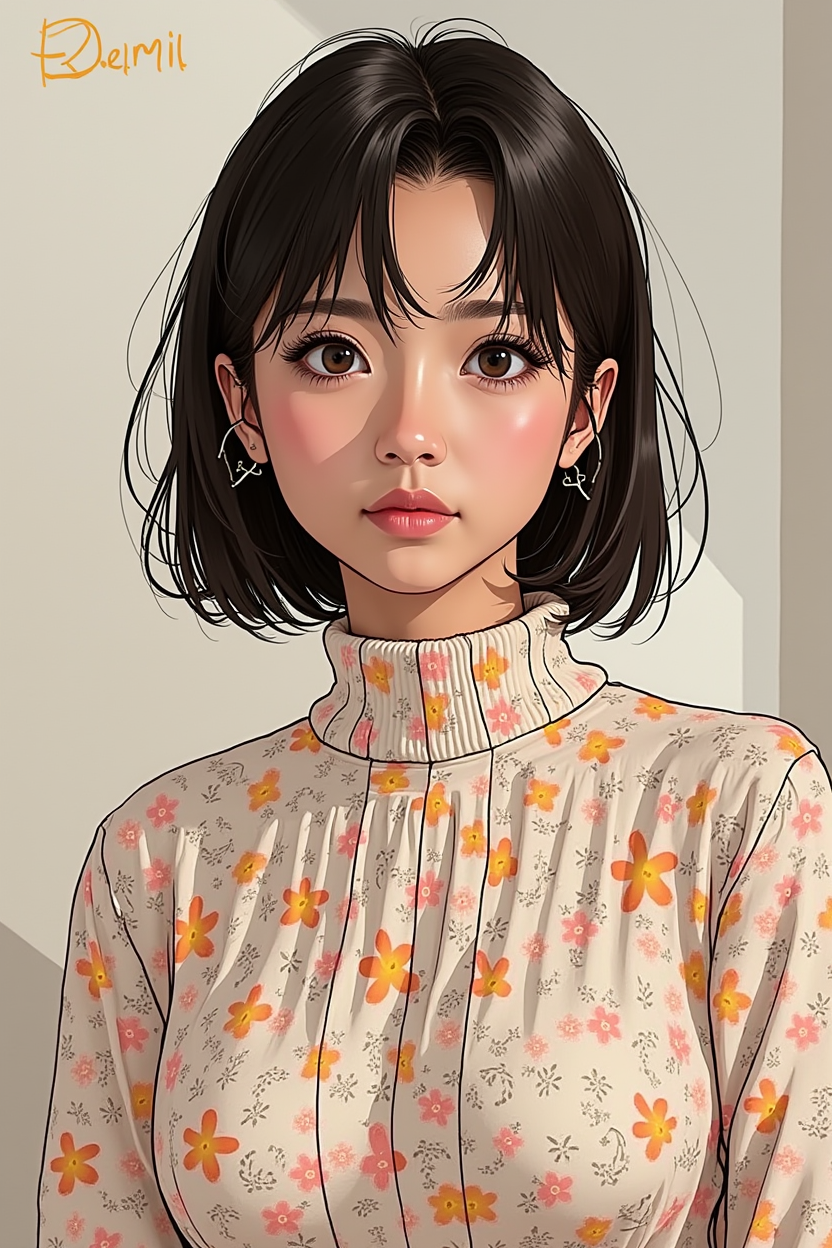

In [2]:
with torch.inference_mode():
    positive_prompt = "anime style"
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 0.75)[0]

    image = nodes.LoadImage().load_image("/content/test.png")[0]
    latent_image = ImageScaleToTotalPixels.upscale(image, "lanczos", 1.0)[0]
    latent_image = VAEEncode.encode(vae, latent_image)[0]

    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

Seed: 2268958356685449561


  0%|          | 0/20 [00:00<?, ?it/s]

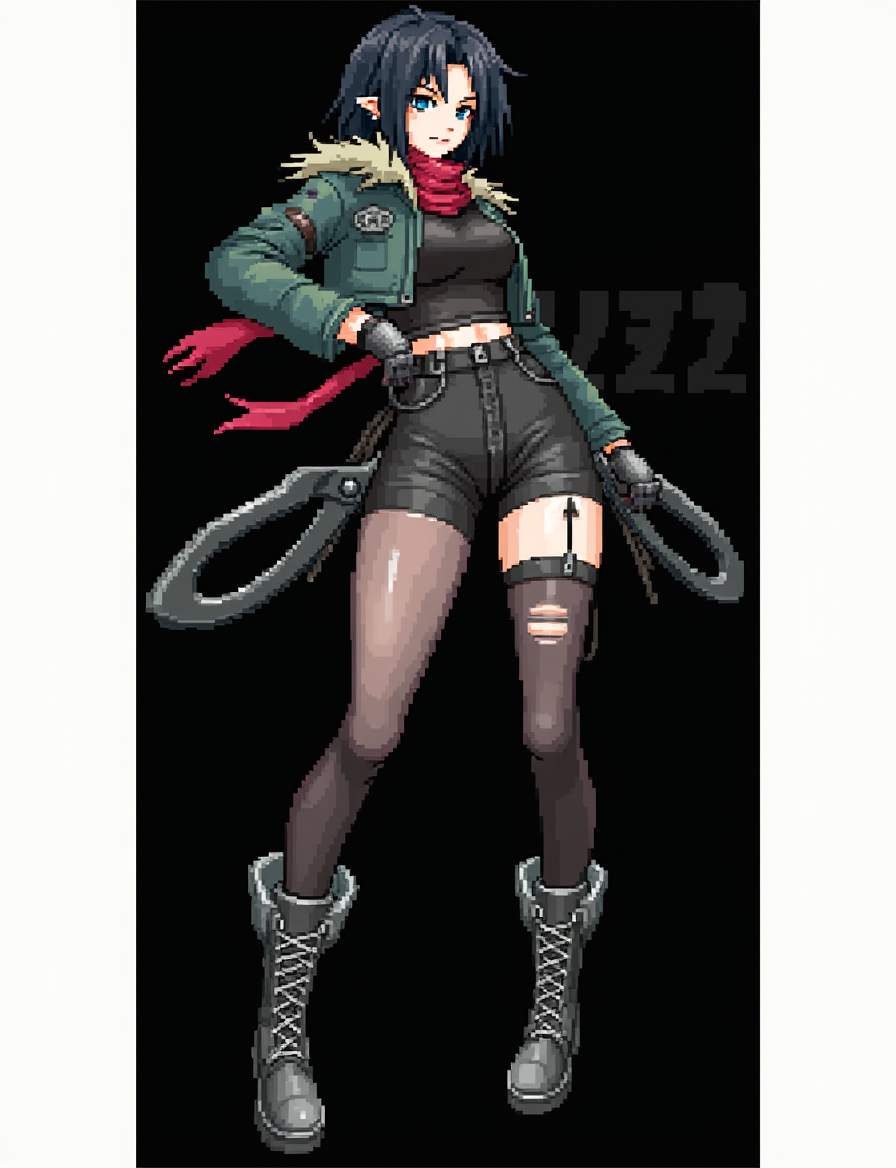

In [13]:
#@title Anime Style Image Generation
#@markdown This code generates an image in an anime style using the specified parameters. The output file name is randomly generated to prevent overwriting.

import torch
import random
import string
from PIL import Image
import numpy as np

# Generate a random file name
def generate_random_filename(length=12):
    letters = string.ascii_lowercase + string.digits
    return ''.join(random.choice(letters) for i in range(length)) + ".png"

output_filename = "/content/" + generate_random_filename()

# Input fields
positive_prompt = "Pixel art anime girl, short black hair, pointed ears, blue eyes, confident smirk, military-style crop jacket with fur collar, black crop top, short shorts, torn stockings, high-tech boots, dual blade weapons, red scarf, 16-bit graphics, retro gaming aesthetic, limited color palette, chunky pixels, no anti-aliasing, sharp pixel edges, low-resolution sprite, SNES era style, 2D side-scrolling game character, simplified pixel details, blocky shapes, pixelated shading, classic arcade look, 8-bit inspired, old-school video game character, square pixels only, mosaic-like appearance, pixel-perfect edges, retro pixel art style, low color depth, nostalgic graphics, dithering effects, cyberpunk elements, contrast between dark outfit and pale skin"  #@param {type:"string"}
width = 512  #@param {type:"slider", min:256, max:2048, step:64}
height = 1024  #@param {type:"slider", min:256, max:2048, step:64}
seed = 0  #@param {type:"number"}
steps = 20  #@param {type:"slider", min:10, max:100, step:5}
sampler_name = "euler"  #@param ["euler", "ddim", "plms", "heun"]
scheduler = "simple"  #@param ["simple", "linear", "cosine"]
image_dir = "/content/IconRole24_webp_resized.png"  #@param {type:"string"}

with torch.inference_mode():
    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(f"Seed: {seed}")

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 0.75)[0]

    image = nodes.LoadImage().load_image(image_dir)[0]
    latent_image = ImageScaleToTotalPixels.upscale(image, "lanczos", 1.0)[0]
    latent_image = VAEEncode.encode(vae, latent_image)[0]

    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save(output_filename)

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])
